<a href="https://colab.research.google.com/github/rohanrajpal/IIITD-sixth-sem/blob/master/Q3Final_Present.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Path Setup
- toc: true

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
PROJECT_PATH = "/content/drive/My Drive/Deep_Learning_Assignments/Assignment2/Q3/"
DATA_PATH_DRIVE = PROJECT_PATH + "asgn2_dataset"
!cp -r "{DATA_PATH_DRIVE}" "/content/"
DATA_PATH = "/content/asgn2_dataset/"
%cd {PROJECT_PATH+"over9000"}

/content/drive/My Drive/Deep_Learning_Assignments/Assignment2/Q3/over9000


In [ ]:
# !nvidia-smi

# Imports


In [ ]:
!pip install livelossplot > /tmp/xxy1
import matplotlib.pyplot as plt
import librosa
import librosa.display
from random import randint
from scipy.io import wavfile
from tqdm import tqdm
from tqdm.auto import tqdm as tq

from torchvision.models import resnet34,densenet121
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import os
from livelossplot import PlotLosses

from sklearn.metrics import confusion_matrix
from plotcm import plot_confusion_matrix
import gc

from functools import partial
from collections import OrderedDict
from torchsummary import summary

if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')
device

device(type='cuda', index=0)

# Helper Functions

In [ ]:
def extractfeatures(origdata,extractfn,rate):
  # print("Orig shape",origdata.shape)
  if (extractfn == librosa.feature.mfcc):
    datamelspectro = extractfn(origdata,sr=rate,n_mfcc=50)
  else:
    datamelspectro = extractfn(origdata,sr=rate)
  # print("Extracted shape",datamelspectro.shape)
  # TODO: fill in the topdb param using the below blog
  # https://medium.com/@hasithsura/audio-classification-d37a82d6715

  return librosa.power_to_db(datamelspectro)

def extract_n_plot(origdata,extractfn,rate,ax):
  # plt.figure()
  # print("After",data.shape)
  librosa.display.specshow(extractfeatures(origdata,extractfn,rate),sr=rate,ax=ax)

def spec_to_image(spec, eps=1e-6):
  # print("Prev shape",spec.shape)
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  return spec_norm

In [ ]:
def pretty_size(size):
  """Pretty prints a torch.Size object"""
  assert(isinstance(size, torch.Size))
  return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
  """Prints a list of the Tensors being tracked by the garbage collector."""
  import gc
  total_size = 0
  for obj in gc.get_objects():
    try:
      if torch.is_tensor(obj):
        if not gpu_only or obj.is_cuda:
          # del obj
          # gc.collect()
          # torch.cuda.empty_cache()
          ((obj.to(torch.device('cpu'))))
          print("%s:%s%s %s" % (type(obj).__name__, 
                      " GPU" if obj.is_cuda else "",
                      " pinned" if obj.is_pinned else "",
                      pretty_size(obj.size())))
          total_size += obj.numel()
      elif hasattr(obj, "data") and torch.is_tensor(obj.data):
        if not gpu_only or obj.is_cuda:
          print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
                           type(obj.data).__name__, 
                           " GPU" if obj.is_cuda else "",
                           " pinned" if obj.data.is_pinned else "",
                           " grad" if obj.requires_grad else "", 
                           " volatile" if obj.volatile else "",
                           pretty_size(obj.data.size())))
          total_size += obj.data.numel()
    except Exception as e:
      pass        
  print("Total size:", total_size)


def clear_gpu_memory(dump_tensor=False):
  if(dump_tensor):
    dump_tensors()
  gc.collect()
  torch.cuda.empty_cache()
# !nvidia-smi

# Part 1 : Visualize Samples


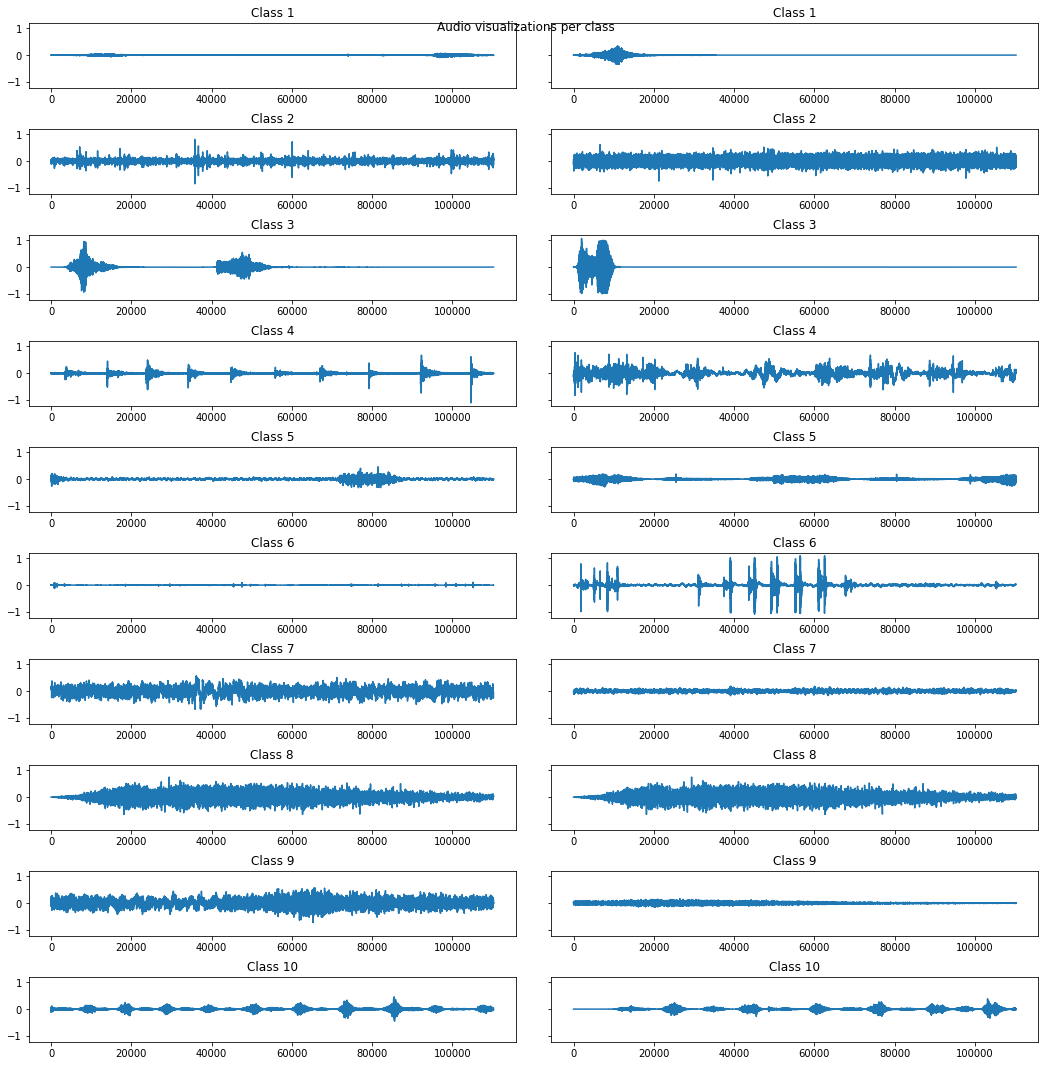

In [ ]:
# def plot_audio():
fig, ax = plt.subplots(10,2, figsize=(15,15),sharey=True)
fig.suptitle('Audio visualizations per class')
fig.tight_layout(pad=2.0)
for i in tq(range(0,10)):
  for k in range(2):
    img_id = randint(1,25)
    data, rate = librosa.load(DATA_PATH+"train/"+str(img_id)+"_"+str(i)+".wav")
    ax[i][k].plot(data)
    ax[i][k].set_title("Class "+str(i+1))
    # show_data(data)
# show_data(data)

In [ ]:
# !ls ./asgn2_dataset

# Part 2 : Extract and Visualize features

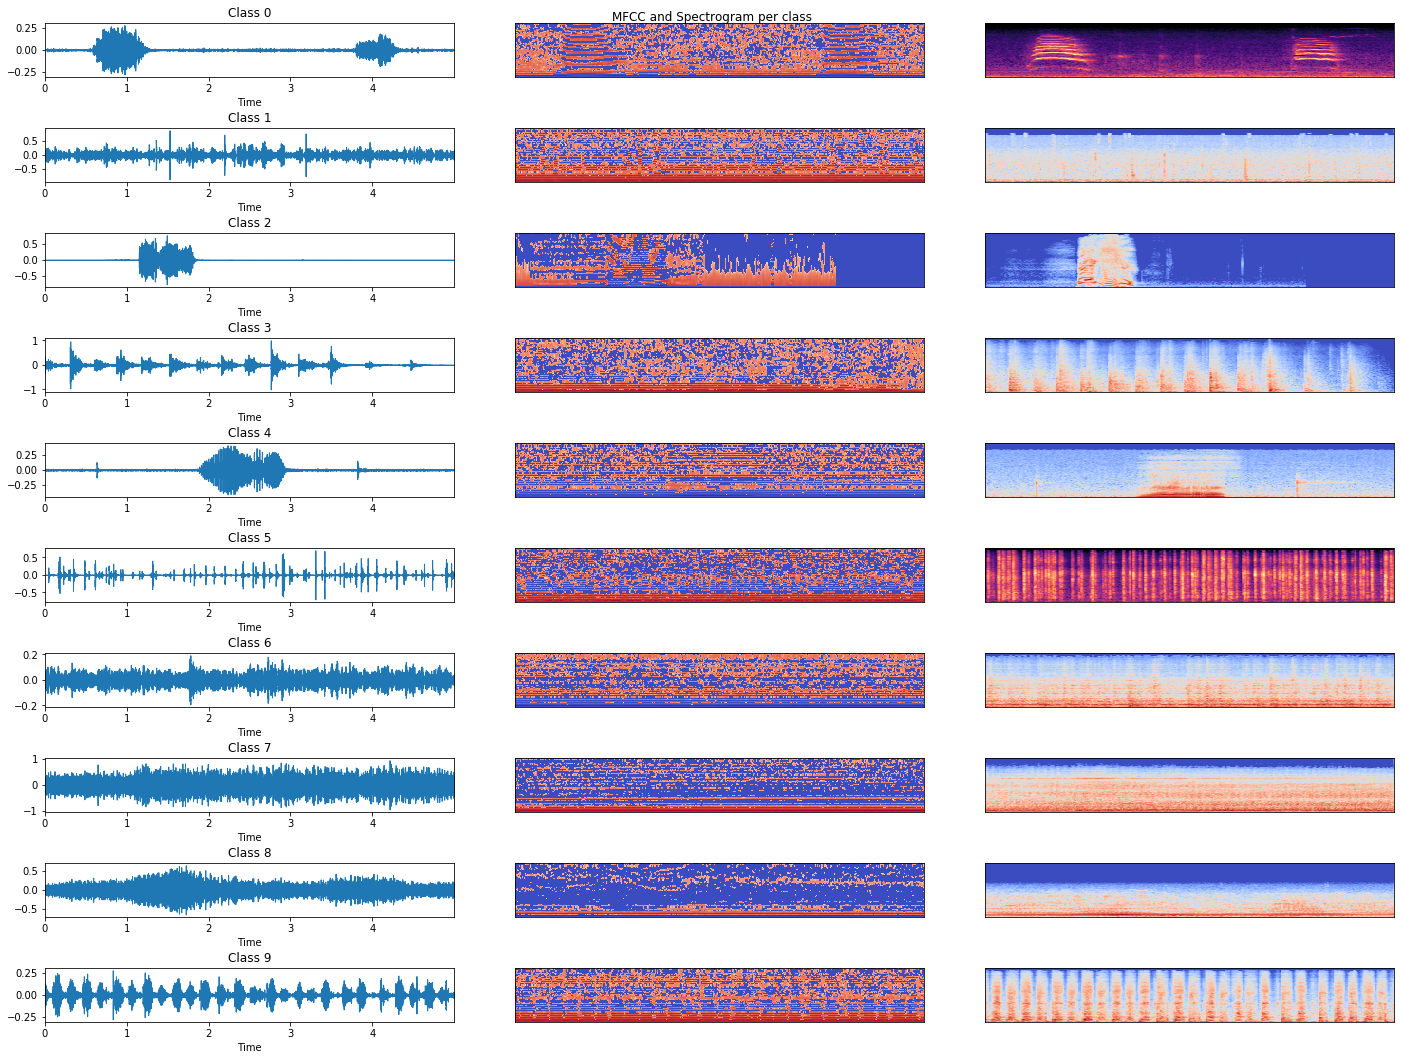

In [ ]:
fig, ax = plt.subplots(10,3, figsize=(20,15))
fig.suptitle('MFCC and Spectrogram per class')
fig.tight_layout(pad=3.0)

sample_rate = 44100

for i in tq(range(0,10)):
  for k in range(1):
    img_id = randint(1,25)
    filename = DATA_PATH+"train/"+str(img_id)+"_"+str(i)+".wav"
    
    origdata, rate = librosa.load(filename,sr=sample_rate)
    # plt.subplot(i,0)
    librosa.display.waveplot(origdata,sr=sample_rate,ax=ax[i,0])
    ax[i,0].set_title("Class "+str(i))
    # print("Before",data.shape)
    extract_n_plot(origdata,librosa.feature.mfcc,rate,ax[i,1])
    # plt.subplot(i,2)
    extract_n_plot(origdata,librosa.feature.melspectrogram,rate,ax[i,2])
    # show_data(data)


# Part 3 : Train a CNN
With MFCC and Spectrogram features

## Split data into train and val

In [ ]:
# Split data into train and val

# !unzip "/content/drive/My Drive/Deep_Learning_Assignments/Assignment2/Q3/asgn2_dataset-compressed.zip"
# !mkdir "/content/drive/My Drive/Deep_Learning_Assignments/Assignment2/Q3/asgn2_"

# DATA_PATH = PROJECT_PATH + "asgn2_dataset/"

# for item in tq(os.listdir(DATA_PATH)):
#   if(item == 'valid' or item == 'train'):
#     continue
#   img_id,img_label = item.split("_")
#   filepath = DATA_PATH + item
#   if int(img_id) <= 25:
#     newpath = DATA_PATH + "train/"
#     !mv "{filepath}" "{newpath}"
#   else:
#     newpath = DATA_PATH + "valid/"
#     !mv "{filepath}" "{newpath}"


## Dataloaders

In [ ]:
class ClassificationData(Dataset):
  def __init__(self, filepath, extractfn,mode):
    self.data = []
    self.labels = []
    self.filenames = []
    
    printonce = False
    for item in tq(os.listdir(filepath)):
      img_id,img_label = item.split("_")
      sample_rate = 44100
      filename = filepath + item
      if(mode == 'raw'):
        sample_rate = sample_rate//2
      origdata, rate = librosa.load(filename,sr=sample_rate)
      
      if not printonce:
        print(origdata.shape)
        printonce =True
      if mode == 'conv':
        self.data.append(spec_to_image(extractfeatures(origdata,extractfn,rate))[np.newaxis,...])
      elif mode == 'time':
        self.data.append(spec_to_image(extractfeatures(origdata,extractfn,rate)).T)
      elif mode == 'raw':
        # size=len(origdata)
        # print()
        # self.data.append(origdata.reshape(size//5,5))
        self.data.append(origdata[np.newaxis,...])

      self.labels.append(int(img_label[0]))
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

def create_dataloader(extractfn,batch_size=50,mode='conv'):
  train_data = ClassificationData(DATA_PATH+"train/", extractfn, mode)
  valid_data = ClassificationData(DATA_PATH+"valid/", extractfn, mode)
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,num_workers=2)
  valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False,num_workers=2)
  return train_loader, valid_loader

In [ ]:
train_loader_mfcc_cnn, valid_loader_mfcc_cnn = create_dataloader(librosa.feature.mfcc)
train_loader_melspec_cnn, valid_loader_melspec_cnn = create_dataloader(librosa.feature.melspectrogram)

In [ ]:
# model = resnet18()
# print(model)

## CNN Architecture

- the model is mainly inspired from resnet18 architecture, since we are treating the sound like an image here


In [ ]:
# Basic CNN
class AudioCNN(nn.Module):
  def __init__(self):
    super(AudioCNN, self).__init__()
    self.conv1 = nn.Conv2d(1,16, kernel_size = 3,stride = 1)
    self.conv2 = nn.Conv2d(16,32,kernel_size=3,stride=1)
    self.conv3 = nn.Conv2d(32,64,kernel_size=3,stride=1)
    self.conv4 = nn.Conv2d(64,128,kernel_size=3,stride=1)
    
    self.maxpool1 = nn.MaxPool2d(2, stride = 2, padding = 0,return_indices = False, ceil_mode = False)
    self.dropout1 = nn.Dropout(p = 0.5, inplace = False)

    self.fc1 = nn.Linear(128 * 60 * 211,128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,10)
    self.BatchNorm64 = nn.BatchNorm1d(64,track_running_stats = True)
    self.relu = nn.ReLU()

  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.conv4(out)
    # print("Before pool",out.shape)
    out = self.maxpool1(out)
    out = self.dropout1(out)
    # print("After pool",out.shape)
    out = out.view(out.size(0), -1)
    # print("After flatten",out.shape)
    out = self.fc1(out)
    out = self.relu(out)

    out = self.fc2(out)
    out = self.BatchNorm64(out)
    out = self.relu(out)

    out = self.fc3(out)
    return out


In [ ]:
# Reference : https://github.com/FrancescoSaverioZuppichini/ResNet/blob/master/ResNet.ipynb
# CNN with residual connections
from functools import partial
from collections import OrderedDict
from torchsummary import summary

class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2)

conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))
    
class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )

class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

class ResNetEncoder(nn.Module):
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

class ResnetDecoder(nn.Module):
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

class ResNet(nn.Module):
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


def resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])

model = resnet18(1, 10)
summary(model.cuda(), (1, 224, 224))

def make_resnet18(in_ch,classes):
  model = resnet18(in_ch,classes)
  model.fc = nn.Linear(512,10)
  model.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  return model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
        Conv2dAuto-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
        Conv2dAuto-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
 ResNetBasicBlock-10           [-1, 64, 56, 56]               0
       Conv2dAuto-11           [-1, 64, 56, 56]          36,864
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
       Conv2dAuto-14           [-1, 64,

## Part 5 and 7 : Training Loop

- optimizer used: Adam, adaptive learning rates help in convergence
- loss: CrossEntropyLoss is used, it is quite common in classification tasks
- around 100 epochs are done and the best model is saved access them [here](https://drive.google.com/drive/folders/167SwM_m0dZz0-by0TrNlPrLjvIPzUw2Q?usp=sharing)


In [ ]:
%time
# %load_ext autoreload
# Reference
# https://medium.com/@hasithsura/audio-classification-d37a82d6715
# from radam import *
# from over9000 import *
def eval(valid_loader, model, loss_compute, plot_matrix):
  model.eval()

  whole_loss = []
  whole_output = []
  whole_label = []

  with torch.no_grad():
    for batch_idx, (data,label) in enumerate(valid_loader):
      # optimizer.zero_grad()
      data, label = data.to(device, dtype=torch.float32), label.to(device)
      
      output = model(data)
      # print(output.shape)
      loss = loss_compute(output,label)
      whole_loss.append(loss.item())
      whole_output.append(output.cpu().detach().numpy())
      # print("Whole",whole_output.shape)
      whole_label.append(label.cpu().detach().numpy())

  whole_label = np.concatenate(whole_label)
  whole_output = np.concatenate(whole_output)
  # print(whole_output.shape)
  # valid_loss.append(np.mean(whole_loss))
  # print("Epoch",i,"val loss",valid_loss[-1])
  whole_output = whole_output.argmax(axis=1)
  accuracy = np.mean(whole_label == whole_output)

  if plot_matrix == True:
    plot_confusion_matrix(confusion_matrix(whole_label,whole_output),[str(x) for x in range(10)])

  return np.mean(whole_loss),accuracy

def train(epochs,data_loader,valid_loader,model,lr,best_wt_name):
  liveplot = PlotLosses(skip_first=0)
  # Optimizer Reference
  # https://github.com/mgrankin/over9000
  optimizer = optim.Adam(model.parameters(),lr=lr)
  loss_compute = nn.CrossEntropyLoss()

  best_model = {'accuracy':0, 'path':PROJECT_PATH + "models/" + best_wt_name}
  # best_accuracy = 0

  for i in tq(range(1,epochs+1)):
    model.train()

    whole_loss = []
    for batch_idx, (data,label) in enumerate(data_loader):
      optimizer.zero_grad()
      # print(batch_idx,data.shape)
      data, label = data.to(device, dtype=torch.float32), label.to(device)
      output = model(data)
      loss = loss_compute(output,label)
      loss.backward()

      whole_loss.append(loss.item())
      optimizer.step()
    
    train_loss = np.mean(whole_loss)
    # print("Epoch",i,"train loss",train_loss[-1])

    valid_loss, accuracy = eval(valid_loader,model,loss_compute,False)

    if best_model['accuracy'] < accuracy:
      best_model['accuracy'] = accuracy
      torch.save(model.state_dict(),best_model['path'])
      # best_model[PROJECT_PATH + "models/" + best_wt_tename]

    # valid_loss.append(loss)
    # print("Accuracy",accuracy)
    # print("------------------------------------------------------------")

    liveplot.update({
        'loss': train_loss,
        'val_loss': valid_loss,
        'val_accuracy' : accuracy
    })
    liveplot.draw()

  # Confusion matrix of the best model
  model.load_state_dict(torch.load(best_model['path']))
  loss,accuracy = eval(valid_loader,model,loss_compute,True)
  print("Best valid accuracy",accuracy)
  

def trainCNN(epochs,data_loader,valid_loader,model_name,pretrained,best_wt_name):
  model = make_resnet18(1,10)
  return train(epochs,data_loader,valid_loader,model,2e-4,best_wt_name)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


### MFCC CNN Model

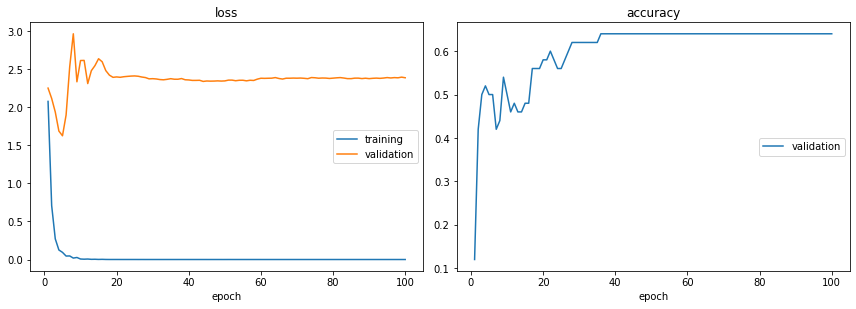

loss:
training   (min:    0.000, max:    2.075, cur:    0.000)
validation (min:    1.624, max:    2.962, cur:    2.385)
validation (min:    0.120, max:    0.640, cur:    0.640)

Confusion matrix, without normalization
Best valid accuracy 0.64


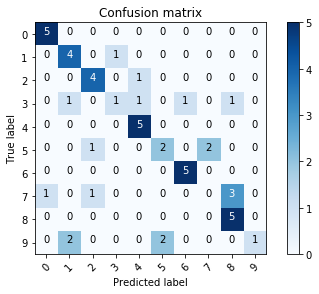

In [ ]:
resnet18_model = trainCNN(100,train_loader_mfcc_cnn,valid_loader_mfcc_cnn,'resnet18',False,'mfcc_cnn_model')
del resnet18_model
clear_gpu_memory()

### Melspec CNN model

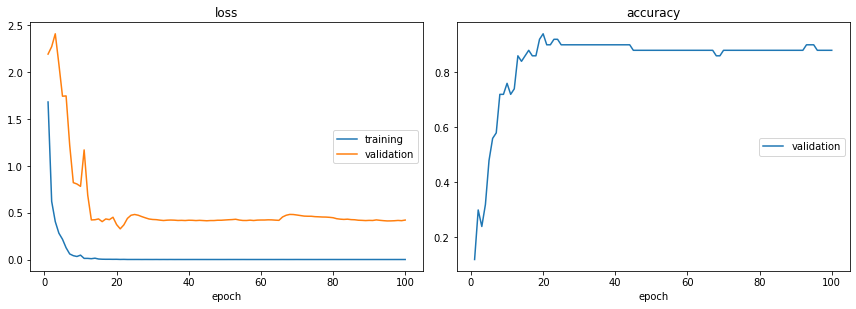

loss:
training   (min:    0.000, max:    1.683, cur:    0.000)
validation (min:    0.328, max:    2.411, cur:    0.421)
validation (min:    0.120, max:    0.940, cur:    0.880)

Confusion matrix, without normalization
Best valid accuracy 0.94


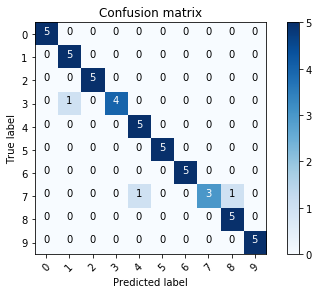

In [ ]:
resnet18_model = trainCNN(100,train_loader_melspec_cnn,valid_loader_melspec_cnn,'resnet18',False,'melspec_cnn_model')
del resnet18_model
clear_gpu_memory()

In [ ]:
%time
# %load_ext autoreload
# Reference
# https://medium.com/@hasithsura/audio-classification-d37a82d6715
# from radam import *
# from over9000.over9000 import *

def trainCNN(epochs,data_loader,valid_loader,model_name,pretrained,best_wt_name):
  if(model_name == 'resnet18'):
    model = resnet18(pretrained=pretrained)
  elif (model_name == 'resnet34'):
    model = resnet34(pretrained=pretrained)
  
  model.fc = nn.Linear(512,10)
  model.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

  # model = AudioCNN()
  model = model.to(device)
  # print("Training")
  liveplot = PlotLosses(skip_first=0)
  # Optimizer Reference
  # https://github.com/mgrankin/over9000
  optimizer = optim.Adam(model.parameters(),lr=2e-4)
  loss_compute = nn.CrossEntropyLoss()

  best_model = {'accuracy':0, 'path':PROJECT_PATH + "models/" + best_wt_name}
  # best_accuracy = 0

  for i in tq(range(1,epochs+1)):
    model.train()

    whole_loss = []
    for batch_idx, (data,label) in enumerate(data_loader):
      optimizer.zero_grad()
      # print(batch_idx,data.shape)
      data, label = data.to(device, dtype=torch.float32), label.to(device)
      output = model(data)
      loss = loss_compute(output,label)
      loss.backward()

      whole_loss.append(loss.item())
      optimizer.step()
    
    train_loss = np.mean(whole_loss)
    # print("Epoch",i,"train loss",train_loss[-1])

    model.eval()

    whole_loss = []
    whole_output = []
    whole_label = []

    with torch.no_grad():
      for batch_idx, (data,label) in enumerate(valid_loader):
        optimizer.zero_grad()
        data, label = data.to(device, dtype=torch.float32), label.to(device)
        
        output = model(data)
        # print(output.shape)
        loss = loss_compute(output,label)
        whole_loss.append(loss.item())
        whole_output.append(output.cpu().detach().numpy())
        # print("Whole",whole_output.shape)
        whole_label.append(label.cpu().detach().numpy())

    whole_label = np.concatenate(whole_label)
    whole_output = np.concatenate(whole_output)
    # print(whole_output.shape)
    # valid_loss.append(np.mean(whole_loss))
    # print("Epoch",i,"val loss",valid_loss[-1])
    whole_output = whole_output.argmax(axis=1)
    accuracy = np.mean(whole_label == whole_output)

    # if plot_matrix == True:
    #   plot_confusion_matrix(confusion_matrix(whole_label,whole_output),[str(x) for x in range(10)])

    valid_loss, accuracy = np.mean(whole_loss),accuracy

    if best_model['accuracy'] < accuracy:
      best_model['accuracy'] = accuracy
      torch.save(model.state_dict(),best_model['path'])
      # best_model[PROJECT_PATH + "models/" + best_wt_tename]

    # valid_loss.append(loss)
    # print("Accuracy",accuracy)
    # print("------------------------------------------------------------")

    liveplot.update({
        'loss': train_loss,
        'val_loss': valid_loss,
        'val_accuracy' : accuracy
    })
    liveplot.draw()

  # Confusion matrix of the best model
  model.load_state_dict(torch.load(best_model['path']))
  loss,accuracy = eval(valid_loader,model,optimizer,loss_compute,True)
  print("Best valid accuracy",accuracy)

# del model
# import gc
# gc.collect()
# resnet18_model = trainCNN(50,train_loader_melspec_cnn,valid_loader_melspec_cnn,'resnet18',False,'melspec_cnn_model')
# resnet18_model = trainCNN(50,train_loader_mfcc_cnn,valid_loader_mfcc_cnn,'resnet18',False,'mfcc_cnn_model')

# Part 4 : LSTM

## LSTM Architecture

- [Reference](https://github.com/sarthak268/Audio_Classification_using_LSTM/blob/master/RNNs.py)

In [ ]:
import torch.nn.functional as F
# Many to one LSTM

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=0.4, batch_first=True)
        self.dropout1 = nn.Dropout(p = 0.5, inplace = False)
        self.fc1 = nn.Linear(hidden_size, hidden_size//2)
        self.fc2 = nn.Linear(hidden_size//2,hidden_size//2)
        self.fc_final = nn.Linear(hidden_size//2,num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        # print(x.shape,h0.shape,c0.shape)
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # print(out.shape)
        # h0 = torch.zeros(self.num_layers, out.size(0), self.hidden_size).to(device) 
        # c0 = torch.zeros(self.num_layers, out.size(0), self.hidden_size).to(device)

        # print(out.shape,h0.shape,c0.shape)
        # out, _ = self.lstm(out, (h0,c0))
        # Decode the hidden state of the last time step
        # out -> 50,431,128
        # print("Before",out[:, -1, :].shape)
        out = self.fc1(out[:, -1, :])
        out = self.dropout1(out)
        out = self.relu(out)
        out = self.relu(self.fc2(out))
        # out = self.fc_final(out)
        # print("After",out.shape)
        # return F.log_softmax(out,dim=1)
        return out

model = RNN(
      input_size=20, hidden_size=128, num_classes=10, num_layers=4
  )
print(model)
# summary(model,(1,20,20))

RNN(
  (lstm): LSTM(20, 128, num_layers=4, batch_first=True, dropout=0.4)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc_final): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)


## Data Loading

In [ ]:
# LSTM Dataloaders
train_loader_mfcc_lstm, valid_loader_mfcc_lstm = create_dataloader(librosa.feature.mfcc,50,'time')
train_loader_melspec_lstm, valid_loader_melspec_lstm = create_dataloader(librosa.feature.melspectrogram,50,'time')


(220500,)



(220500,)



(220500,)



(220500,)



## Part 5 and 7 : Training Loop

- training loop is same as that of CNN for a fair competition


In [ ]:
def trainLSTM(epochs,data_loader,valid_loader,sequence_length,input_size,best_wt_name):
  model = RNN(
      input_size=input_size, hidden_size=128, num_classes=10, num_layers=2
  ).to(device)

  return train(epochs,data_loader,valid_loader,model,2e-4,best_wt_name)

### Melspec LSTM

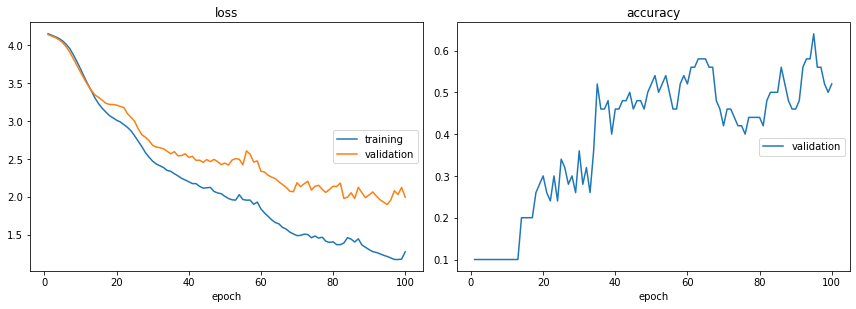

loss:
training   (min:    1.169, max:    4.152, cur:    1.271)
validation (min:    1.896, max:    4.140, cur:    1.993)
validation (min:    0.100, max:    0.640, cur:    0.520)

Confusion matrix, without normalization
Best valid accuracy 0.64


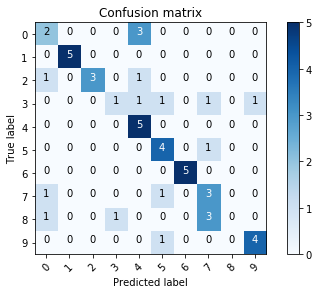

In [ ]:
tmp = trainLSTM(100,train_loader_melspec_lstm,valid_loader_melspec_lstm,431,128,'melspec_lstm_model')
del tmp
clear_gpu_memory()

### MFCC LSTM

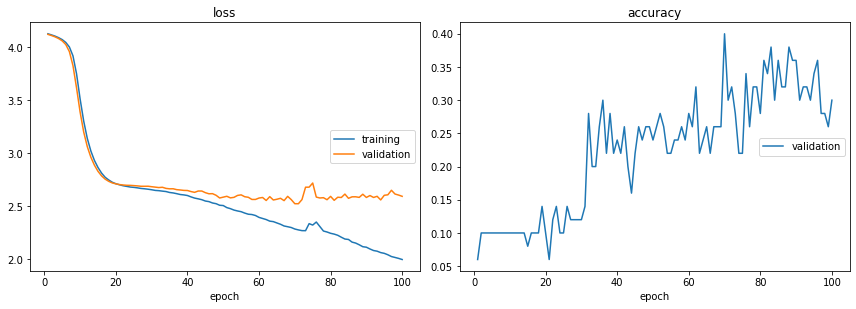

loss:
training   (min:    1.999, max:    4.128, cur:    1.999)
validation (min:    2.525, max:    4.122, cur:    2.595)
validation (min:    0.060, max:    0.400, cur:    0.300)

Confusion matrix, without normalization
Best valid accuracy 0.4


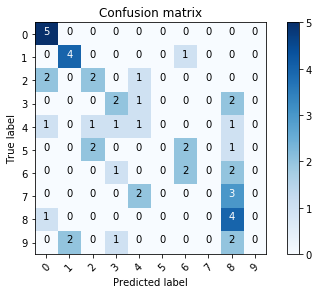

In [ ]:

tmp = trainLSTM(100,train_loader_mfcc_lstm,valid_loader_mfcc_lstm,431,50,'mfcc_lstm_model')
del tmp
clear_gpu_memory()

### Raw Audio LSTM

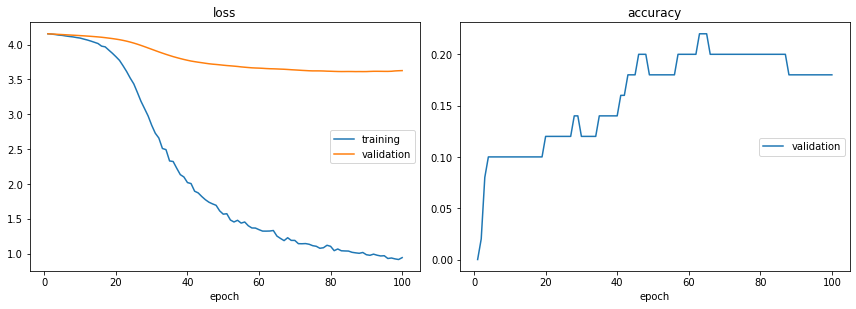

loss:
training   (min:    0.915, max:    4.155, cur:    0.942)
validation (min:    3.613, max:    4.156, cur:    3.627)
validation (min:    0.000, max:    0.220, cur:    0.180)

Confusion matrix, without normalization
Best valid accuracy 0.22


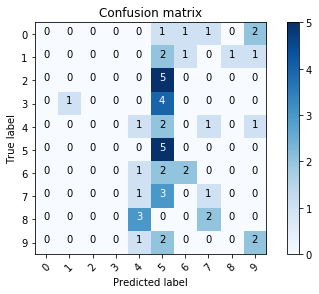

In [ ]:
# train_loader_raw_lstm, valid_loader_raw_lstm = create_dataloader(None,50,'raw')
tmp = trainLSTM(100,train_loader_raw_lstm,valid_loader_raw_lstm,1,55125*2,'raw_lstm_model')
del tmp
clear_gpu_memory()

# Comparision between CNN and LSTM

We can see that CNNs perform much better than LSTM, possible reasons can be
- CNN are pretty good at classification
- Quite a complex CNN architecture has been used compared to the LSTM one
- LSTMs are usually preferred in generation tasks than classification tasks, that is when sequential information helps more

# Testing

(220500,)

Confusion matrix, without normalization
Test data loss 0.3731626272201538 accuracy: 0.94


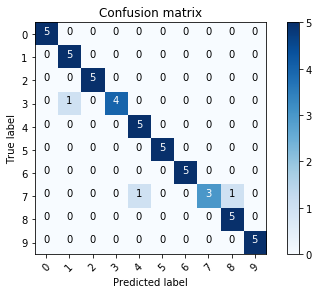

In [ ]:
TEST_FOLDER_PATH = DATA_PATH + "valid/"

valid_data = ClassificationData(TEST_FOLDER_PATH, librosa.feature.melspectrogram, 'conv')
valid_loader = DataLoader(valid_data, batch_size=50, shuffle=False,num_workers=2)
best_model = resnet18(1,10)
best_model.fc = nn.Linear(512,10)
best_model.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

best_model.load_state_dict(torch.load(PROJECT_PATH+"submission_models/models/" + "melspec_cnn_model"))
best_model = best_model.to(device)
# print(best_model)
# optimizer = optim.Adam(best_model.parameters(),lr=2e-4)
loss_compute = nn.CrossEntropyLoss()

loss, accuracy = eval(valid_loader, best_model, loss_compute, True)

print("Test data loss",loss,"accuracy:",accuracy)

# References

[visualize](https://github.com/devinvenable/mfcc-audio-experiment/blob/master/MFCC%20transforms.ipynb)

[audio-classification-pytorch](https://medium.com/@hasithsura/audio-classification-d37a82d6715)